# 3b_CBA_part2

Part 2 of the cost-benefit analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from scipy.spatial import distance

### Loading the data

In [9]:
data = pd.read_csv('../assets/data_sh/train_data_raw.csv')
data['Date'] = pd.to_datetime(data['Date'])
spray_data = pd.read_csv('../assets/spray.csv')


# Spraying phenomenon

The city used Zenivex dispersed on the ground from trucks. The active ingredient in Zenivex has a half-life of 1.5 days in water and 4.4 days in soil [source](https://vector.sccgov.org/sites/g/files/exjcpb676/files/Zenivex%20FAQs%20June%202020.pdf).

When sprayed, the the treatment does not stay in a given area but drifts through the neighborhood with air currents, becomes more diluted. The effect is probably the strongest at the epicenter of the spray.

In [10]:
spray_data.head(3)

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157


In [135]:
# spraying data is only available for two years 2011 and 2013
spray_events = len(spray_data['Date'].unique())
print(f'There are {spray_events} spray events in the data')
spray_data['Date'].value_counts()


There are 10 spray events in the data


2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

The spray data provided is scant, with a coverage of spraying in 2011 and 2013. 

A **spray event** is defined as a single day where spraying occurs. For a single spray event, there could be 90-1000s of spray sites that are sprayed throughout that one day. In the data there are only 10 spray events.

Two in 2011, and another eight in 2013 between the months of July and September.


# Visualizing each spray event

In [11]:
spray_plot_data = spray_data.copy()

fig = px.scatter_mapbox(spray_plot_data, lat="Latitude", lon="Longitude",
                        zoom=8, width=600, height=650,
                        animation_frame='Date')


fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

The chart is interactive and the slider can be used to change the spray event. 

From the visualization it is clear that each spray event is targeted and localized to a specific area.

In [13]:
# spray and traps on the same map
fig = px.scatter_mapbox(spray_plot_data, lat = 'Latitude', lon  = 'Longitude',
                        size_max=15, zoom = 9, color_discrete_sequence=["palegoldenrod"], opacity = 0.5)

fig2 = px.scatter_mapbox(data, lat = 'Latitude', lon  = 'Longitude',
                        hover_data = ['Trap'], zoom = 9)

fig.add_trace(fig2.data[0],)

fig.update_layout( title = 'Spray - West Nile Virus and Mosquito clusters',
                width=500, height=700)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

The trap sites (blue) are displayed with the spray sites (yellow) for all years. Not all trap sites are affected by the spraying, which means any data on spray efficacy will be limited by the placement of the traps.

# Efficacy for each spray event

The efficacy of each spray event is studied by considering the traps that were affected by the spray. 

In [12]:
# limiting the data to years 2011 and 2013, when spray events occurred
mask = (data['Date'] >= '2011-01-01') & (data['Date'] <= '2013-12-31')
data = data.loc[mask]

# creating a df with trap coordinates
traps = data.groupby('Trap').agg({'Latitude': 'mean', 'Longitude': 'mean'})
traps['coordinates'] = traps.apply(lambda x: (x['Latitude'], x['Longitude']), axis=1)

# creating a column with spray coordinates
spray_data['Date'] = pd.to_datetime(spray_data['Date'])
spray_data['coordinates'] = spray_data.apply(lambda x: (x['Latitude'], x['Longitude']), axis=1)

# creating a list with the spray event dates
event_dates = list(spray_data['Date'].unique())

This functions finds the shortest distance from a trap to a spray site - for a particular spray event (i.e. for a particular day).

In [140]:
def update_distance(site, row):
    calc_distance = distance.euclidean(site, row['coordinates'])
    row['spray_distance'] = min(row['spray_distance'], calc_distance)
    return row

In [141]:
# for each event date, find the distance between a trap and the closest spray site

# how close a trap has to be, before it is considered as sprayed
distance_threshold = 0.0005*3

# to store the information by spray event, there are 10
event_info = {}

for event_date in event_dates:
    # reinitialise spray distance as large as possible
    traps['spray_distance'] = 10000

    # list of spray coordinates for a particular date
    spray_sites = spray_data.loc[spray_data['Date']==event_date, 'coordinates']

    for site in spray_sites:
        # for spray site, update each trap's distance to the closest spray site
        traps = traps.apply(lambda x: update_distance(site, x), axis=1)
    
    # after all sites have been scanned for a particular date
    # filter traps that are within the distance threshold
    traps_affected = list(traps[traps['spray_distance'] < distance_threshold].index)

    event_info[str(event_date)[0:10]] = traps_affected

    print(f'For event {event_date}, {traps_affected}')


For event 2011-08-29T00:00:00.000000000, []
For event 2011-09-07T00:00:00.000000000, ['T223']
For event 2013-07-17T00:00:00.000000000, ['T008', 'T089', 'T159']
For event 2013-07-25T00:00:00.000000000, ['T218', 'T228']
For event 2013-08-08T00:00:00.000000000, ['T147']
For event 2013-08-15T00:00:00.000000000, ['T013', 'T144', 'T151', 'T230']
For event 2013-08-16T00:00:00.000000000, ['T017']
For event 2013-08-22T00:00:00.000000000, ['T138', 'T227']
For event 2013-08-29T00:00:00.000000000, ['T028', 'T066', 'T231']
For event 2013-09-05T00:00:00.000000000, ['T233']


The printout ('event_info) shows traps affected by each spray event. In each dictionary entry, only the traps that are close to a spray site are considered. 

As a limitation of this approach, weather and wind were not considered. Instead, the distance_threshold (for whether a trap was considered) was set to be very narrow so the traps studied are almost at the epicenter of the spray and should have the full-effect of the spray.

### Plotting each spray event

For each spray event, the traps are identified and the Number of Mosquitos in the traps are plotted over time.  

The spray event is also plotted on the chart as a vertical red line. For the first spray event, there were no traps in proximity. 

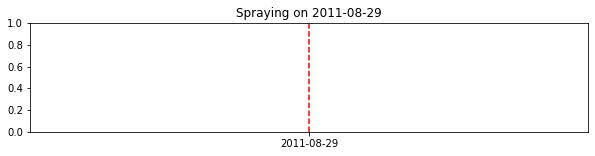

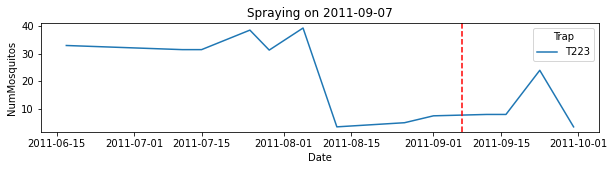

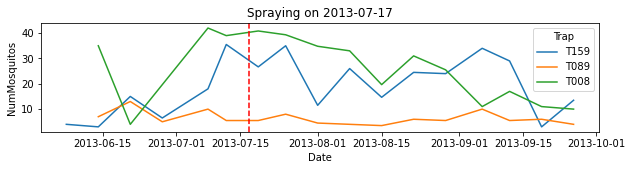

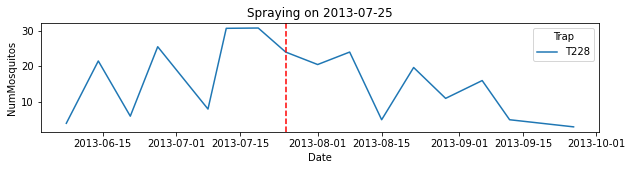

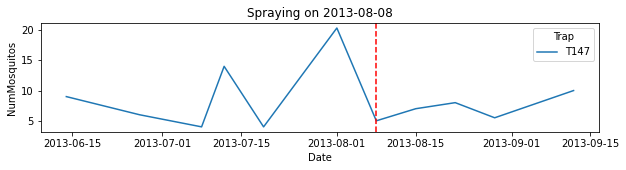

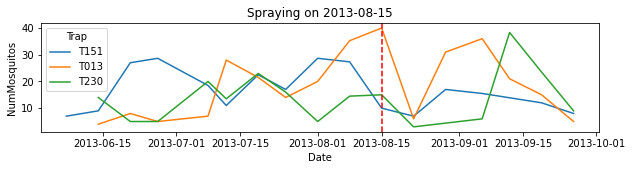

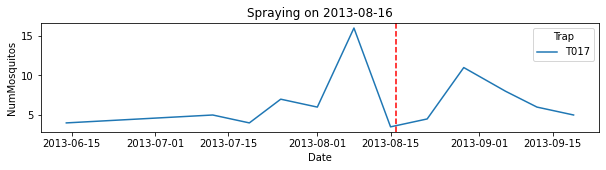

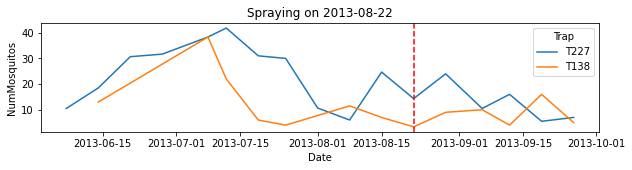

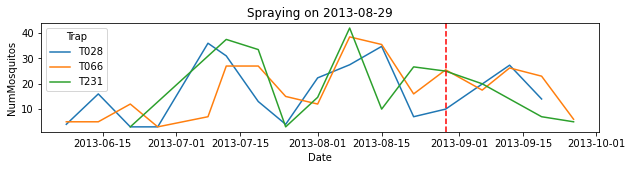

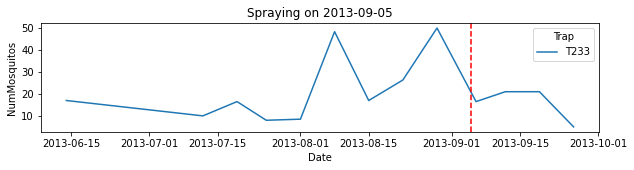

In [150]:
for date, value in event_info.items():
    event_year = date[:4]
    traps_affected_by_event = value
    
    # first narrow down the time frame to the event year
    plot_data = data.set_index('Date').loc[event_year].reset_index()

    # then slice the data to the traps affected 
    plot_data = plot_data[plot_data['Trap'].isin(traps_affected_by_event)]

    # make plot with the spray event as a vertical red line
    fig, ax = plt.subplots(figsize=(10,2)) 
    
    (sns.lineplot(x='Date', y='NumMosquitos', hue='Trap', data=plot_data, ci=None)
     .set_title(f'Spraying on {date}'))

    plt.axvline(x = date, color = 'r', linestyle = '--');


# Interpreting the spray efficacy

Spraying affects the number of mosquitos for traps in proximity. 
For each of the 10 spray events, the plots show how the number of mosquitos in the traps changed over time. 
For the 10 spray events:

- One event is inconclusive. **2011-08-29 spray event** had no traps in proximity

- Two events suggest some efficacy. The **2013-07-25 spray event** caused the number of mosquitos in trap T228 to decrease over the next 3 weeks. Similarly, the **2013-08-15 spray event** caused the number of mosquitos in traps T013, T230, and T151 to decrease over the following weeks.

- The remaining 7 spray events saw the number of mosquitos in affected traps actually increase in the following weeks after spraying. 

Causality is difficult to determine as the testing schedule was not designed as an experiment to test the efficacy of the spraying. Very few traps were in the spray zones and trap data was collected at irregular intervals (not every day). Furthermore, traps with no mosquitos, essentially a sign that spraying was successful, are not even recorded in the data.

Looking at the data, it is not possible to determine if spraying has any benefit for controlling the mosquito population, a crucial vector in the spread of the West Nile Virus in this geography.

# CBA Conclusion

The CBA is inconclusive as the benefits of spraying are ambiguous from the data.

### Benefits of spraying

From a benefit standpoint, the effectiveness spray events in 2011 and 2013 are inconclusive. A recent 2022 study on the [Impact of Adulticide on Culex Abundance](https://meridian.allenpress.com/jamca/article/38/1/46/478857/The-Impact-of-Adulticide-on-Culex-Abundance-and) suggests that _"a single spray event may not be enough to control vector mosquito abundance and serial spraying, weather permitting, every 5 days... should be evaluated."_.

The study also notes post-spray rebounds 5 days after spraying, which may be what is observed in the Chicago 2011/13 data. It is however, difficult to conclude with certainty, as the affected traps are not checked on a routine schedule.

Overall, the benefit of the 2011/13 campaigns is wholly ambiguous. 

### Costs of spraying

As discussed in CBA_part1, the cost of spraying to cover the entire city is around US\$2mil, which is roughly equivalent to 32% of the economical loss,  for a single spray event. This covers 606 km<sup>2</sup> of land without adjusting for urban effects. 

A proper spray campaign will require multiple spray events and drive this cost up further. The exact frequency of application is hard to determine without proper data on spray efficacy in Chicago's geography. However, we present a feasible lower bound for future calculations.

